# Алгоритмы кластеризации

Основная задача этого задания - реализация одного из алгоритмов кластеризации.
Кроме того, необходимо будет проверить корректность работы алгоритма на тестовых данных, проверить работу алгоритма на данных различной природы, подбирать параметры алгоритма.

In [1]:
import random
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)


## Реализация алгоритма

Необходимо выбрать и реализовать самостоятельно один из следующих алгоритмов кластеризации:
* Агломеративная иерархическая кластеризация с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)
* DBSCAN. (параметры - epsilon, min_pts) - нужно самостоятельно разобрать и применить критерий качества для DBSCAN
* OPTICS(\*). (параметры - epsilon, min_pts)
* Gaussian Mixture Model(\*\*) с использованием maximum a-posteriori для выбора кластера (параметр - k)

(\*) - алгоритм не был разобран на занятии. Выбирайте этот пункт только если уверенно умеете программировать и хотите разобраться с более сложной идеей, чем DBSCAN  
(\*\*) - алгоритм не был разобран на занятии, задание повышенной сложности. Выбирайте этот пункт только если хотите разобраться со сложным математическим обоснованием и точно уверены, что сможете запрограммировать и отладить.

## Интерфейс
Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [2]:
from sklearn.base import BaseEstimator, ClusterMixin

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, eps=1, min_pts=4):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        
        # Save parameters in model
        self.eps = eps
        self.min_pts = min_pts
        
        return
    
    def _region_query(self, X, point_idx):
        """
        Find neighbors within eps-neighborhood for point with index point_idx in dataset X
        """
        neighbors = []
        
        # Calculate distances from given point to points from X dataset
        # and get all neighbors within eps-neighborhood
        distances = np.linalg.norm(X[point_idx] - X, axis=1) 
        neighbors = [i for i in range(self.X_len_) if distances[i] <= self.eps]
        
        # Divide by 2 partitions, with min_pts points in the first partition
        partition_idx = np.argpartition(distances, self.min_pts)
        
        # Calculate mean distance from given point to min_pts points
        # according to the article https://habr.com/post/322034/
        self.mean_dist_[point_idx] = distances[partition_idx][:self.min_pts].mean()
        
        # Calculate distance from given point to min_pts-th point
        # according to the article https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf
        self.k_dist_[point_idx] = distances[partition_idx][:self.min_pts].max()
        
        # Return indices in dataset X for the neighbors of the point with index point_idx
        return neighbors
    
    
    def _expand_cluster(self, X, core_point_idx, neighbors, C):
        """
        Find all points for the cluster C with core point with index core_point_idx 
        """
        
        self.labels_[core_point_idx] = C
        i = 0
        
        # Iterate for all density-connected points for cluster C
        while i < len(neighbors):
            # Get next point
            point_idx = neighbors[i]
            
            # For noise points
            if self.labels_[point_idx] == -1:
                # Change class label to C
                self.labels_[point_idx] = C
            # For unprocessed point
            elif self.labels_[point_idx] == 0:
                # Change class label to C
                self.labels_[point_idx] = C
                
                # Get indices for all neighbors for this point
                point_neighbors = self._region_query(X, point_idx)
                
                # If this point is core point
                if len(point_neighbors) >= self.min_pts:
                    # Include all neighbors to the list of point to check
                    neighbors = neighbors + point_neighbors
                # Otherwise, it is edge point, therefore do nothing
            
            i = i + 1
        
    
    def fit(self, X, y=None):
        """
        Use data matrix x to compute model parameters
        """
        
        # Initialize parameters which are fitted using dataset X
        self.X_len_ = len(X)
        self.labels_ = np.zeros(self.X_len_)
        self.mean_dist_ = np.zeros(self.X_len_)
        self.k_dist_ = np.zeros(self.X_len_)
        C = 0
        
        # For each point in dataset X
        for point_idx in range(self.X_len_):
            # If point is already processed
            if not (self.labels_[point_idx] == 0):
                # Do nothing
                continue
            
            # Get indices for all neighbors for this point
            neighbors = self._region_query(X, point_idx)
            
            # If there are less than min_pts in eps_neighborhood
            if len(neighbors) < self.min_pts:
                # Mark this point as noise
                self.labels_[point_idx] = -1
            else:
                # Otherwise, create new cluster
                C = C + 1
                # Find all density-connected points for cluster C
                self._expand_cluster(X, point_idx, neighbors, C)
        
        return self
    
    def predict(self, X):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        
        # Return class labels for the fitted model
        return self.labels_
        
    def fit_predict(self, X, y=None):
        # Fit the model 
        self.fit(X, y)
        
        # Predict classes for the data using fitted model
        return self.predict(X)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

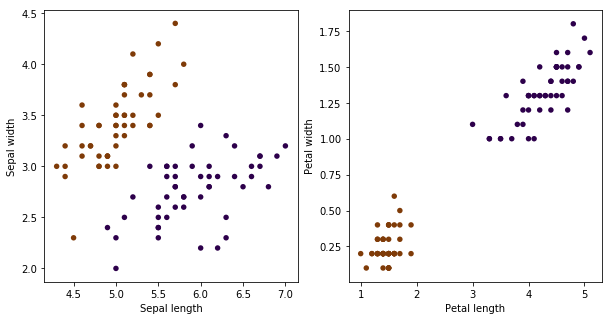

In [3]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма. 

**Примечание**  
В описании данной задачи указано - "В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма."  
Для данного задания, чтобы получить оценку, близкую к 1, возможна не некорректная реализация алгоритма, а необходим также подбор параметров (несмотря на то, что задание на поиск параметров указано после этой задачи). 

В описании задачи на поиск параметров, для DBSCAN указано следующее - "Для DBSCAN применяется эвристика по подсчету среднего расстояния до min-pts точек, их сортировки, далее применяется критерий локтя (описание https://habrahabr.ru/post/322034/ или http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)"
В данных статьях, судя по всему, рассматриваются 2 разные эвристики:  
- В первой статье, предлагается для каждой точки взять среднее расстояние до min_pts точек, отсортировать полученные значения в порядке возрастания, и взять "точку перегиба" ("локоть") как значение для eps.  
min_pts обычно берется в диапазоне от 3 до 9.
- Во второй статье, предлагается для каждой точки взять расстояние до min_pts-й точки (k-dist), отсортировать полученные значения в обратном порядке, и взять также "точку перегиба" ("локоть") как значение для eps, и точки с расстоянием > k-dist будут считаться точками шума, а точки с расстоянием <= k-dist - точками, которые будут отнесены к некоторому кластеру. Как я понял из данной статьи, выбранное значение eps можно двигать в зависимости от того, какой уровень шума предполагается в данных. На основе выбранного значения eps, на графике берется соответствующее значение min_pts.

После тестирования обоих методов, решено для примера взять метод из второй статьи (оригинальной статьи по DBSCAN)  

Во второй статье для оценки параметра eps используется значение min_pts=4, которое получено экспериментальным путем (для данных размерности 2). В дальнейшем, для оценки параметров, также будет использоваться min_pts=4.

Создадим модель с начальными параметрами (eps=1, min_pts=4) и проверим значение Adjusted Rand Index

In [4]:
model = Clustering(min_pts=4)
pred_iris = model.fit_predict(x_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 1.00


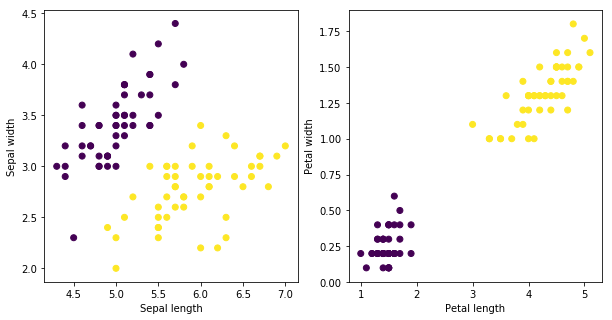

In [5]:
pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=pred_iris)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=pred_iris)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

На основе значения ARI и графиков видно, что кластеризация со значениями по умолчанию отработала идеально.

Нарисуем кривую k_dist, и проверим, насколько хорошо отработает подбор параметров по данной эвристике

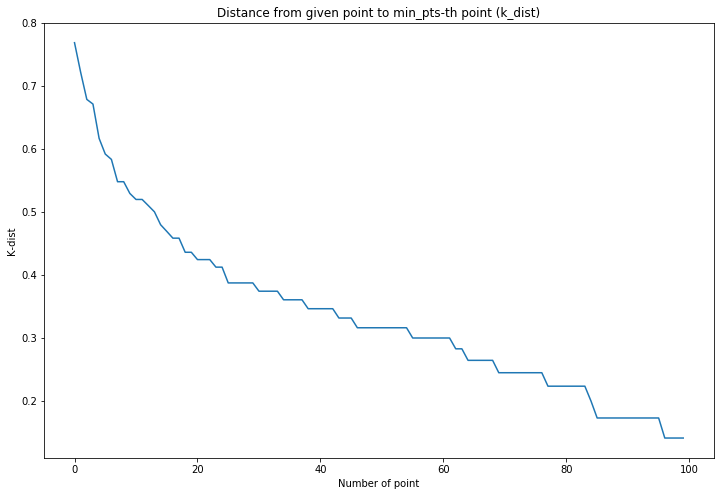

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))

sorted_k_dist = sorted(model.k_dist_, reverse=True)
ax.plot(sorted_k_dist)
ax.set_title('Distance from given point to min_pts-th point (k_dist)')
ax.set_xlabel('Number of point')
ax.set_ylabel('K-dist')

plt.show()

In [7]:
sorted_k_dist[:10]

[0.76811457478686096,
 0.72111025509279791,
 0.67823299831252637,
 0.67082039324993692,
 0.61644140029689787,
 0.5916079783099617,
 0.58309518948452965,
 0.54772255750516641,
 0.54772255750516619,
 0.52915026221291805]

Для k_dist, судя по всему, исходя из второй статьи, необходимо выбрать значение eps около 0.68, где есть первый "перегиб" (что подтверждают первые 10 значений sorted k-dist)
Данному значению eps соответствует k=3, возьмем его в качестве значения для min_pts

Adjusted Rand index for iris is: 1.00


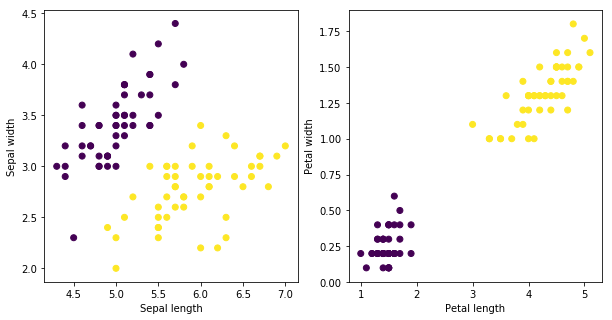

In [8]:
model = Clustering(eps=0.68, min_pts=3)
pred_iris = model.fit_predict(x_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=pred_iris)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=pred_iris)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

**Вывод**  
Как видно по ARI и графику, кластеризация также идеальная (относительно известных классов в данных), эвристика сработала.

Подобрать параметры модели с использованием эвристик и критериев качества. 

Критерий локтя:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

Для DBSCAN применяется эвристика по подсчету среднего расстояния до min-pts точек, их сортировки, далее применяется критерий локтя (описание https://habrahabr.ru/post/322034/ или http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров, а так же при необходимости изменить этот код (для DBSCAN). На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров. Возможно, необходимо построить такую визуализацию несколько раз.

**Примечание**  
В случае с DBSCAN, непонятно, нужно ли реализовывать данный код. Т.к. DBSCAN выбирает сам кол-во кластеров, судя по всему, реализация не нужна (подбор параметров для датасета iris был выполнен ранее) - **подтверждено преподавателем**

Далее необходимо кластеризовать с помощью реализованного алгоритма данные, используемые для демонстраций на предыдущих занятиях. Предлагается сделать сравнение с реализацией из sklearn.

Построим sorted k-dist для всех 4 датасетов с min_pts=4, и сохраним sorted k-dist для каждого из датасетов, для поиска значений eps и min_pts согласно эвристике

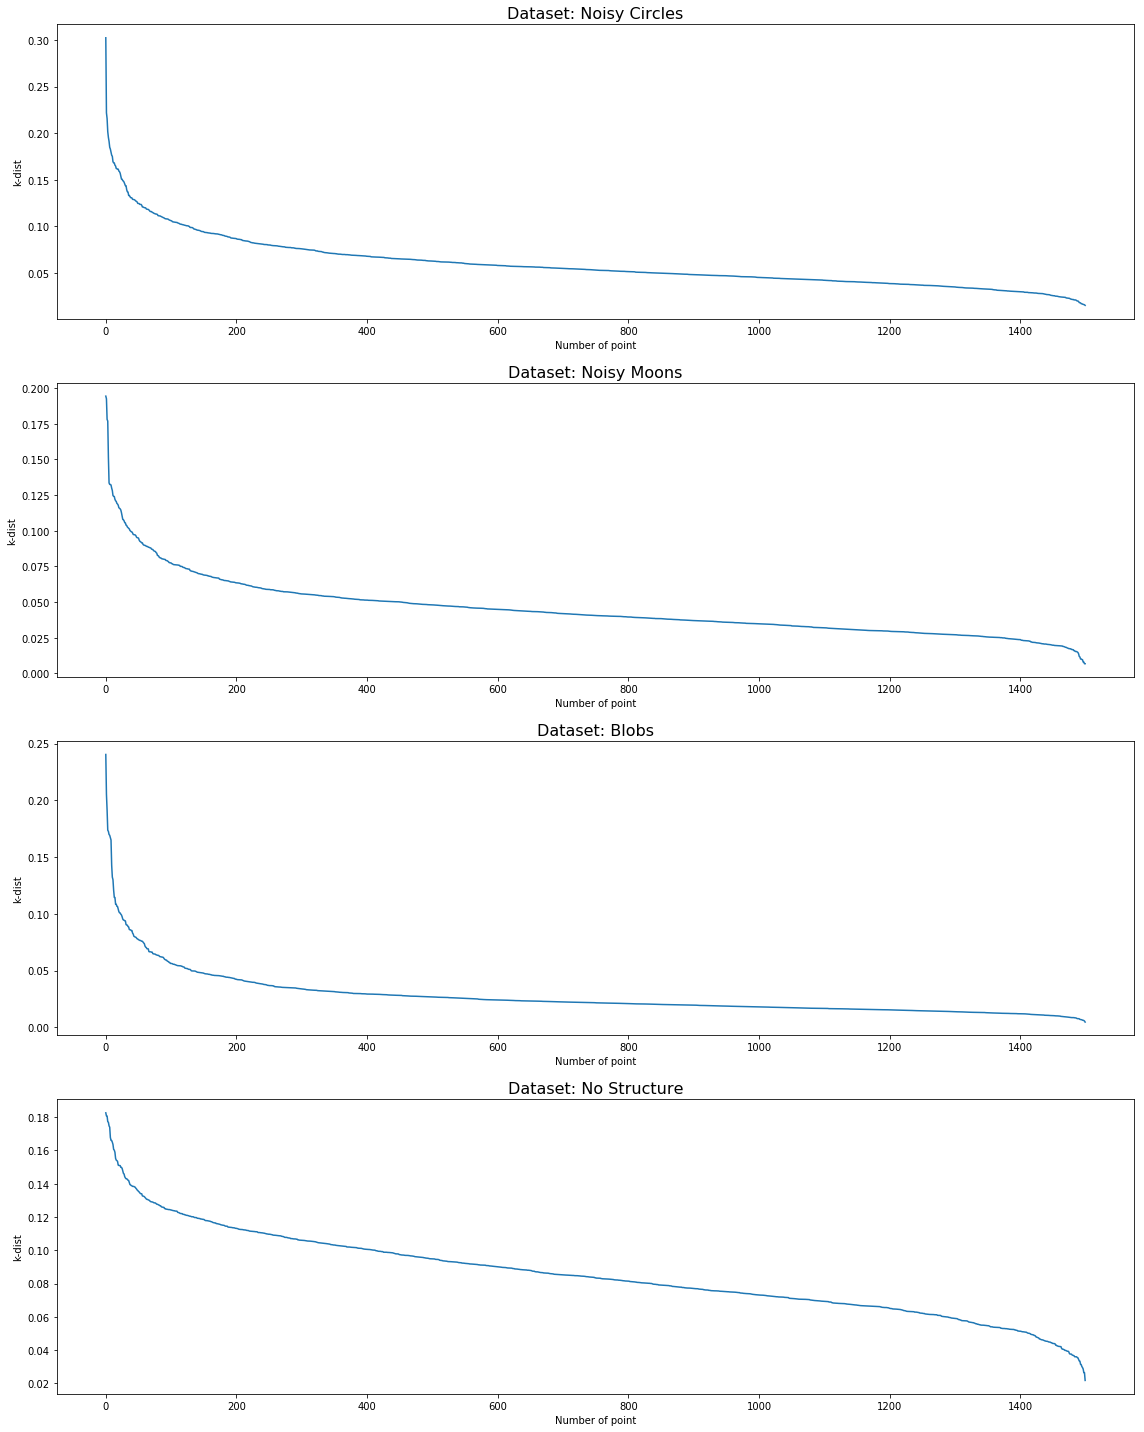

In [9]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None


fig_kw = {'figsize': (16, 20)}
fig, axes = plt.subplots(4, 1, **fig_kw)

sorted_k_distances = []
min_pts = 4

data = [noisy_circles, noisy_moons, blobs, no_structure]
data_labels = ['Noisy Circles', 'Noisy Moons', 'Blobs', 'No Structure']

for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    model = Clustering(min_pts=min_pts)
    y_pred = model.fit_predict(X)
    
    sorted_k_dist = sorted(model.k_dist_, reverse=True)
    axes[i_dataset].plot(sorted_k_dist)
    axes[i_dataset].set_title('Dataset: {}'.format(data_labels[i_dataset]), fontsize=16)
    axes[i_dataset].set_xlabel('Number of point')
    axes[i_dataset].set_ylabel('k-dist')
    
    sorted_k_distances.append(sorted_k_dist)

    fig.tight_layout(h_pad=1.5)
    
plt.show()

Для более точного определения параметров, отобразим для каждого из датасетов первые 50 точек sorted k-dist

In [10]:
for i, sorted_k_dist in enumerate(sorted_k_distances):
    print('Dataset: {}'.format(data_labels[i]))
    print(np.round(sorted_k_dist[:50], 5))
    print()

Dataset: Noisy Circles
[ 0.30238  0.22181  0.21558  0.20155  0.19535  0.19114  0.18487  0.18287
  0.17951  0.17632  0.17511  0.16934  0.16813  0.16801  0.16561  0.16471
  0.16198  0.16178  0.16138  0.16132  0.1593   0.1586   0.15698  0.15408
  0.15069  0.15053  0.14893  0.14852  0.14728  0.14529  0.14358  0.14351
  0.13924  0.13705  0.13683  0.13309  0.13308  0.13191  0.13073  0.13067
  0.1304   0.12892  0.12884  0.1287   0.12841  0.12783  0.12707  0.12674
  0.12604  0.12454]

Dataset: Noisy Moons
[ 0.19437  0.19253  0.17806  0.1769   0.15135  0.13355  0.13246  0.13242
  0.13209  0.12987  0.12823  0.12469  0.12418  0.12405  0.12202  0.12103
  0.12052  0.11918  0.11872  0.11793  0.11618  0.1158   0.11534  0.11454
  0.11262  0.11034  0.10793  0.10772  0.10695  0.10569  0.1055   0.10391
  0.10369  0.10266  0.10218  0.10169  0.10127  0.10019  0.09976  0.0993
  0.09918  0.09845  0.09739  0.0973   0.09721  0.09708  0.09658  0.09554
  0.09515  0.09504]

Dataset: Blobs
[ 0.24037  0.2053   0.19

Исходя из полученных данных, можно предположить (оценка субъективная), что данные имеют первые "перегибы" в точках:
- Noisy Circles: eps = 0.185, min_pts = 7    
- Noisy Moons: eps = 0.134, min_pts = 6    
- Blobs: eps = 0.170, min_pts = 6  
- No Structure: eps = 0.177, min_pts = 4  

Создадим модели с полученными параметрами, и оценим графически и по значениям ARI качество кластеризации (ARI не оценивается для датасета No Structure, т.к. данный датасет не размечен).
Для сравнения, дополнительно построим кластеры с использованием модели DBSCAN из sklearn

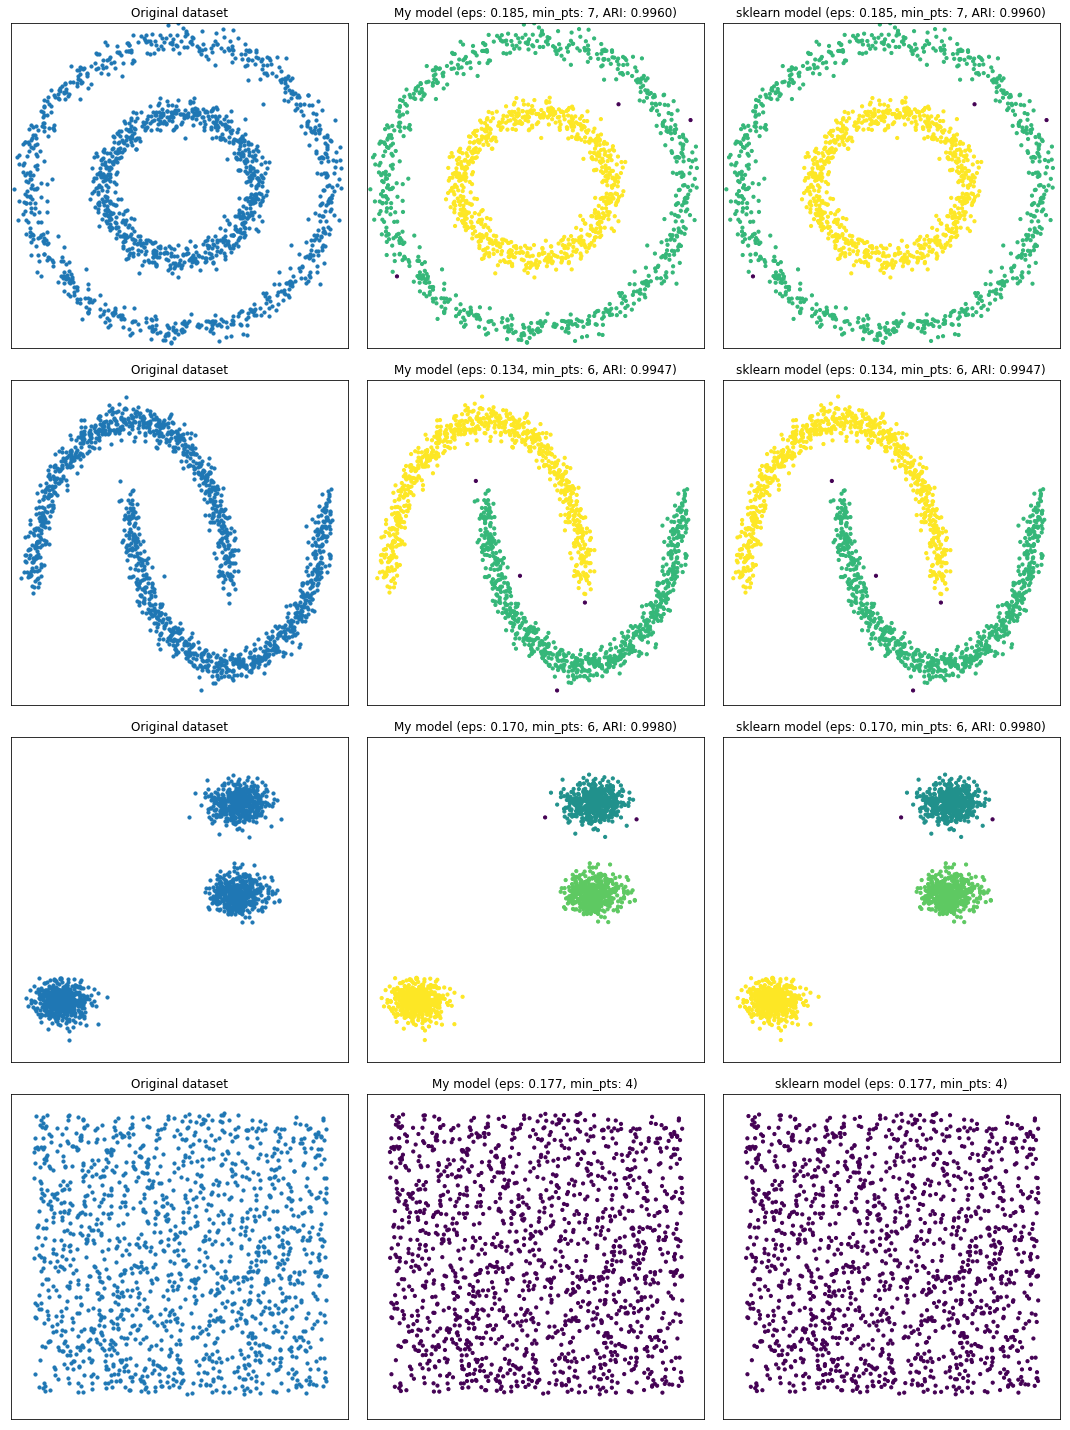

In [11]:
from sklearn.cluster import DBSCAN

fig_kw = {'figsize': (15, 20)}
fig, axes = plt.subplots(4, 3, **fig_kw)
plt.setp(axes, xlim=(-2, 2), ylim=(-2, 2), xticks=(), yticks=())

eps_params = [0.185, 0.134, 0.170, 0.177]
min_pts_params = [7, 6, 6, 4]

data = [noisy_circles, noisy_moons, blobs, no_structure]

for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    model = Clustering(eps=eps_params[i_dataset], min_pts=min_pts_params[i_dataset])
    y_pred = model.fit_predict(X)
    
    axes[i_dataset, 0].scatter(X[:, 0], X[:, 1], s=10) 
    axes[i_dataset, 0].set_title('Original dataset')
    
    axes[i_dataset, 1].scatter(X[:, 0], X[:, 1], s=10, c=y_pred)

    if y is not None:
        title = 'My model (eps: {:.3f}, min_pts: {}, ARI: {:.4f})'.format(model.eps, model.min_pts,
                                                       smt.adjusted_rand_score(y, y_pred))
        axes[i_dataset, 1].set_title(title)
    else: 
        title = 'My model (eps: {:.3f}, min_pts: {})'.format(model.eps, model.min_pts)
        axes[i_dataset, 1].set_title(title)
    
    sk_model = DBSCAN(eps=eps_params[i_dataset], min_samples=min_pts_params[i_dataset])
    sk_y_pred = model.fit_predict(X)
    
    axes[i_dataset, 2].scatter(X[:, 0], X[:, 1], s=10, c=sk_y_pred)
    
    if y is not None:
        title = 'sklearn model (eps: {:.3f}, min_pts: {}, ARI: {:.4f})'.format(sk_model.eps, sk_model.min_samples,
                                                       smt.adjusted_rand_score(y, sk_y_pred))
        axes[i_dataset, 2].set_title(title)
    else: 
        title = 'sklearn model (eps: {:.3f}, min_pts: {})'.format(model.eps, model.min_pts)
        axes[i_dataset, 2].set_title(title)
    
    fig.tight_layout(pad=1.2)
    
plt.show()

**Вывод**  
Даже несмотря на субъективный выбор параметров, исходя из графиков и значения ARI, кластеризация успешна для всех 4 датасетов - выделены необходимые кластеры, а также обнаружены наиболее "шумные" точки.  
Результаты реализованного алгоритма полностью совпадают с результатами модели DBSCAN из sklearn

Код ниже не использовался, т.к. проверка работы реализованного алгоритма была реализована выше

## Дополнительное задание (не является обязательным)


Примените три любых алгоритма кластеризации из библиотеки sklearn на выбранном вами датасете (реальные данные, датасет с kaggle и пр.). Желательно выбрать легко интерпретируемые данные - например, данные о товарах или пользователях, где есть название, пол, возраст, а так же любые другие легко воспринимаемые признаки.

После применения алгоритма покажите в каждом кластере несколько представителей и проинтерпретируйте результат.

Не делал, решил больше времени посвятить основному заданию, а так же сложно было найти датасет, который можно было бы использовать для этого без особых усилий на его предварительную обработку (без feature engineering, с числовыми фичами малой размерности, чтобы можно было его интерпретировать после кластеризации)